# 0.1 Introduction and libraries

In [1]:
import sys, os
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.python.ops import math_ops
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras import layers
from tensorflow.keras import models
from ESN import EchoStateRNNCell
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.io import loadmat
from IPython.display import display, clear_output

# memory growth
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

# print a progres bar for the cell
from IPython.display import HTML, display
import time
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# random numbers
random_seed = np.frombuffer(os.urandom(4), dtype=np.uint32)[0]
print("seed: ", random_seed)

2023-11-13 16:36:43.796028: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-13 16:36:43.932239: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-13 16:36:43.932273: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-13 16:36:43.932305: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-13 16:36:43.952085: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-13 16:36:46.153225: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

seed:  416443524


# 0.2 Preparing The dataset

# The dataset generator

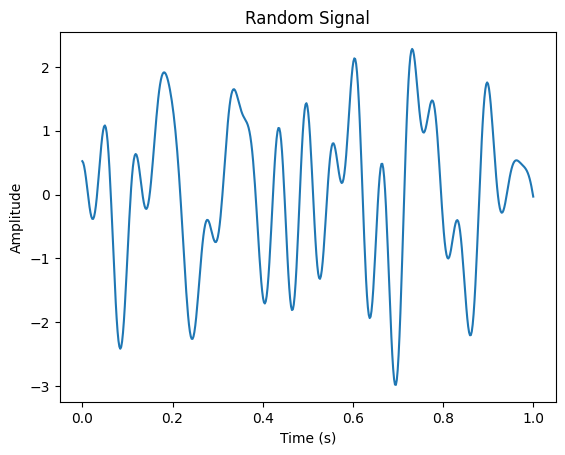

In [2]:

def generate_random_signal(lower_freq, upper_freq, duration, sample_rate, num_components):
    """
    Generates a time signal with random Fourier composition within the given frequency range.

    Args:
        lower_freq (float): Lower bound for frequencies.
        upper_freq (float): Upper bound for frequencies.
        duration (float): Duration of the signal in seconds.
        sample_rate (int): Number of samples per second (sampling rate).

    Returns:
        numpy.ndarray: Generated time signal.
    """
    num_samples = int(duration * sample_rate)
    time = np.linspace(0, duration, num_samples)
    signal = np.zeros(num_samples)

    for _ in range(num_components):
        freq = np.random.uniform(lower_freq, upper_freq)
        phase = np.random.uniform(0, 2 * np.pi)
        amplitude = np.random.uniform(0.1, 1.0)
        component = amplitude * np.sin(2 * np.pi * freq * time + phase)
        signal += component

    return signal

if __name__ == "__main__":
    lower_freq = 5      # Lower bound for frequencies
    upper_freq = 20     # Upper bound for frequencies
    duration = 1        # Duration of the signal in seconds
    sample_rate = 500   # Number of samples per second (sampling rate)
    num_components = 5  # Random number of Fourier components


    # Generate the random signal
    signal = generate_random_signal(lower_freq, upper_freq, duration, sample_rate, num_components)

    # Plot the signal
    time = np.linspace(0, duration, len(signal))
    plt.plot(time, signal)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Random Signal')
    plt.show()

# 0.3. Define ESN

In [3]:
class EchoStateRNNCell(layers.Layer):
    def __init__(self, units, activation, epsilon, alpha, optimize, optimize_vars, seed,
                 input_scaling, spectral_radius, leakage_rate, decay):
        super(EchoStateRNNCell, self).__init__()
        self.units = units
        self.activation = activation
        self.epsilon = epsilon
        self.alpha = alpha
        self.optimize = optimize
        self.optimize_vars = optimize_vars
        self.seed = seed
        self.input_scaling = input_scaling
        self.spectral_radius = spectral_radius
        self.leakage_rate = leakage_rate
        self.decay = decay  # Add the decay parameter

        # Specify the state_size attribute as a tuple
        self.state_size = (self.units,)

    def build(self, input_shape):
        input_dim = input_shape[-1]

        # Initialize your cell parameters here
        self.kernel = self.add_weight("kernel",
                                      shape=(input_dim + self.units, self.units),
                                      initializer="glorot_uniform",
                                      trainable=True)
        self.recurrent_kernel = self.add_weight("recurrent_kernel",
                                                shape=(self.units, self.units),
                                                initializer="orthogonal",
                                                trainable=True)

        # Scale the recurrent weights to achieve the desired spectral radius
        self.recurrent_kernel = self.spectral_radius * self.recurrent_kernel / max(np.linalg.norm(self.recurrent_kernel), 1)

    def call(self, inputs, states):
        prev_output = states[0]

        # Your cell logic goes here
        new_output = (1 - self.leakage_rate - self.decay) * prev_output + self.leakage_rate * self.activation(
            tf.matmul(tf.concat([inputs, prev_output], axis=-1), self.kernel) +
            tf.matmul(prev_output, self.recurrent_kernel)
        )

        return new_output, [new_output]

    def get_config(self):
        return {
            "units": self.units,
            "activation": tf.keras.activations.serialize(self.activation),
            "epsilon": self.epsilon,
            "alpha": self.alpha,
            "optimize": self.optimize,
            "optimize_vars": self.optimize_vars,
            "seed": self.seed,
            "input_scaling": self.input_scaling,
            "spectral_radius": self.spectral_radius,
            "leakage_rate": self.leakage_rate,
            "decay": self.decay
        }

# 0.4 Reshape the input data

In [4]:
# Reshape the input data
rnn_inputs = signal.reshape(1, -1, 1)
rnn_targets = np.roll(signal, -1).reshape(1, -1, 1)  # Shift targets by 1 time step

# 0.5 Initialize the ESN and set parameters for ESN

In [5]:
# Set parameters for the ESN
input_scaling = 0.5
spectral_radius = 0.9
num_units = 100
leakage_rate = 0.2
decay = 0.1  # You can adjust the decay parameter

# Create an instance of EchoStateRNNCell
echo_state_rnn_cell = EchoStateRNNCell(units=num_units,
                                       activation=tf.keras.activations.tanh,
                                       epsilon=1e-20,
                                       alpha=0.5,
                                       optimize=True,
                                       optimize_vars=["rho", "decay", "alpha", "sw"],
                                       seed=42,
                                       input_scaling=input_scaling,
                                       spectral_radius=spectral_radius,
                                       leakage_rate=leakage_rate,
                                       decay=decay)

# Build the recurrent layer
recurrent_layer = layers.RNN(echo_state_rnn_cell, input_shape=(None, 1),
                             return_sequences=True, name="esn_rnn")

# Build the output layer
output_layer = layers.Dense(1, name="readouts")

# Compile the model
model = models.Sequential()
model.add(recurrent_layer)
model.add(output_layer)
model.compile(optimizer='adam', loss='mse')

# Display the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 esn_rnn (RNN)               (None, None, 100)         10100     
                                                                 
 readouts (Dense)            (None, None, 1)           101       
                                                                 
Total params: 10201 (39.85 KB)
Trainable params: 10201 (39.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# 0.6 Training

In [6]:
%reload_ext tensorboard

In [7]:
tensorboard --logdir=tensorboard

Reusing TensorBoard on port 6006 (pid 336978), started 6 days, 23:10:23 ago. (Use '!kill 336978' to kill it.)

In [8]:
logdir="tensorboard"

In [9]:
summary_writer = tf.summary.create_file_writer(logdir)

In [11]:
# 0.5.1. Run a training on the outputs

In [13]:
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))
'''
def progress_bar(current, total, length=30):
    progress = int(length * current / total)
    bar = f"[{'#' * progress}{'-' * (length - progress)}] {current}/{total}"
    return bar
'''
epochs = 100  # Adjust the number of epochs as needed
losses = np.zeros(epochs)
out = display(progress(0, epochs), display_id=True)

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        outputs = model(rnn_inputs)
        current_loss = tf.reduce_mean(tf.square(outputs - rnn_targets))

    grads = tape.gradient(current_loss, model.trainable_variables) 
    model.optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    losses[epoch] = current_loss.numpy()

    # Log the loss to TensorBoard
    with summary_writer.as_default():
        tf.summary.scalar('loss', current_loss, step=epoch)

    # Update the progress bar
    out.update(progress(epoch + 1, epochs))

# Close the TensorBoard summary writer
summary_writer.close()

# 0.7 Loss curve

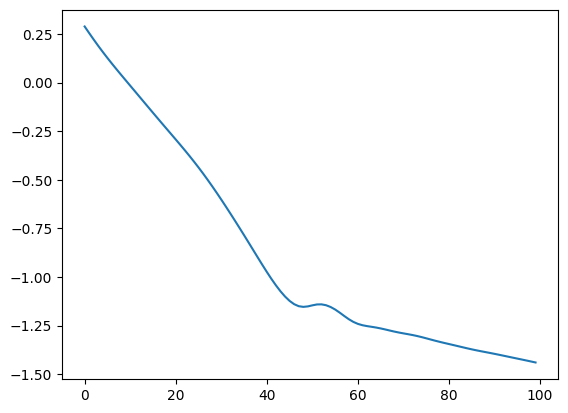

In [15]:
p = plt.plot(np.log10(losses))
plt.show()


# 0.8 Predicted Model vs Trained Model

1/1 [==============================] - 0s 219ms/step


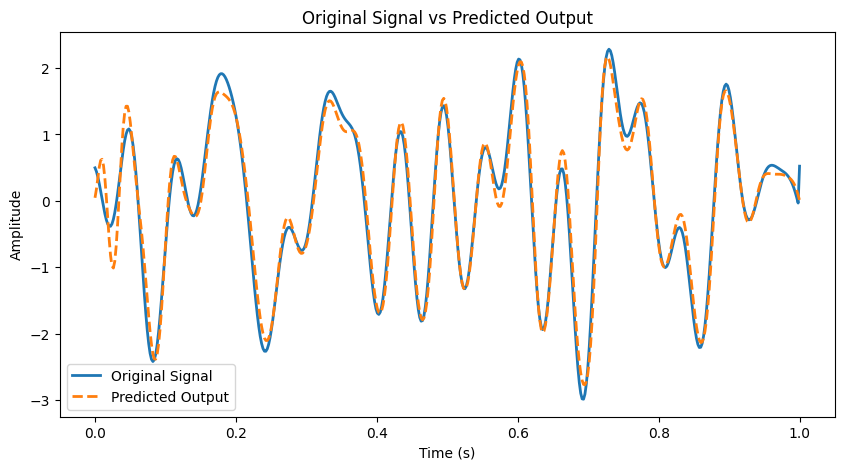

In [16]:
# Generate predictions using the trained model
predicted_outputs = model.predict(rnn_inputs)

# Reshape the predictions and original signal for plotting
predicted_outputs = predicted_outputs.reshape(-1)
rnn_targets = rnn_targets.reshape(-1)

# Plot the original signal and predicted output
plt.figure(figsize=(10, 5))
plt.plot(time, rnn_targets, label='Original Signal', linewidth=2)
plt.plot(time, predicted_outputs, label='Predicted Output', linestyle='dashed', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original Signal vs Predicted Output')
plt.legend()
plt.show()